# Robot Trading

## Parte 1: Configuración del ambiente

***Vamos a realizar la importación de las bibliotecas y las variables globales que necesitaremos para trabajar en el proyecto***

In [1]:
import pandas as pd

import numpy as np

import yfinance as yf

import matplotlib.pyplot as plt

from bs4 import BeautifulSoup; import requests

from IPython.display import clear_output

import time

global algoritmo_decision, decisión, df_bitcoin, df_bitcoin_limpio, media_bitcoin, precio_actual, tendencia

## Parte 2: Obtención de datos

***En esta sección definiremos las dos funciones necesarias para obtener el DataFrame de los valores históricos del Bitcoin, el precio actual y el indicador de tendencia***

### Definición de funciones

In [2]:
def importar_base_bitcoin():
    
    global df_bitcoin
    df_bitcoin = yf.Ticker('BTC-USD').history(period = '7d', interval = '2m')
#Función de obtención de los datos históricos del valor del Bitcoin (BTC-USD)
# en un periodo de una semana con intervalos de 2 minutos

def extraer_tendencias():
    
    global precio_actual, tendencia
    
    url = 'https://coinmarketcap.com/'
    headers = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko)Chrome/113.0.0.0 Safari/537.36'}
    response = requests.get(url, headers = headers)
    soup = (BeautifulSoup(response.content, 'html.parser')).tbody
    filas = soup.find_all('p', {'class' : 'sc-4984dd93-0 iqdbQL coin-item-symbol'} )
    indice_fila = 0

    for row in filas:
        
        if row.getText() == 'BTC':
            
            break
        
        else:
            
            indice_fila += 1
    #Con este contador ubicamos la fila en la que se encuentra el Bitcoin, esto está pensado para casos en los que ya no se
    # encuentre en primera posición, pero también es fácilmente modificable para obtener los valores de otras criptomonedas

    precio_actual = float(soup.find_all('tr')[indice_fila].find_all('td')[3].getText().replace('$', '').replace(',', ''))
    tendencia = ''
    
    if soup.find_all('tr')[indice_fila].find_all('td')[4].span.span['class'][0] == 'icon-Caret-up':
        
        tendencia = 'Alta'
        
    else:
        
        tendencia = 'Baja'
#Función que obtiene el valor del precio actual del Bitcoin y el indicador de tendencia

# Parte 3: Limpieza de datos

***En esta sección definiremos la función para realizar la limpieza de la muestra de datos y obtener el valor promedio***

## Definición de la función

In [3]:
def limpieza_datos():
    
    global df_bitcoin, df_bitcoin_limpio, media_bitcoin
    
    df_bitcoin_limpio = df_bitcoin.copy()
    df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin.index.duplicated()]
    #Copiamos el DataFrame original para trabajar sobre la copia y eliminamos los índices duplicados

    df_bitcoin_limpio.dropna(subset = ['Close'], inplace=True)
    #Eliminamos todos los valores 'Nan' de la columna 'Close' del DataFrame
    
    df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]
    #Eliminamos todos los valores iguales o menores a cero de la columna 'Volume' del DataFrame
    
    Valor = df_bitcoin_limpio['Close']
    Q1 = Valor.quantile(.25)
    Q3 = Valor.quantile(.75)
    IIQ = Q3 - Q1
    limite_inferior = Q1 - (1.5 * IIQ)
    limite_superior = Q3 + (1.5 * IIQ)
    #Calculamos los valores de nuestra gráfica boxplot con los que filtraremos los datos

    filtro_outliers = (Valor >= limite_inferior) & (Valor <= limite_superior)
    df_bitcoin_limpio = df_bitcoin_limpio[filtro_outliers]
    #Con estas dos líneas de código eliminamos los outliers en caso de existir

    filtro_q1_q3 = (Valor >= Q1) & (Valor <= Q3)
    df_bitcoin_limpio = df_bitcoin_limpio[filtro_q1_q3]
    #Con estas dos líneas de código seleccionamos solo los valores entre el Q1 y Q3

    df_bitcoin_limpio.reset_index(inplace = True)
    #Reasignamos el index después de haber hecho el filtro a los datos
    
    media_bitcoin = round(df_bitcoin_limpio['Close'].mean(), 2)
    #Calculamos la media de los valores de la columna 'Close' del DataFrame y redondeamos a 2 decimales

# Parte 4: Toma de decisiones

***En esta sección vamos a definir la función para el algoritmo de toma de decisiones***

## Definición de la función

In [4]:
def tomar_decisiones():
    
    global decisión
    
    if (precio_actual >= media_bitcoin) and (tendencia == 'Baja'):
        
        decisión = 'Vender'
        
    elif (precio_actual <= media_bitcoin) and (tendencia == 'Alta'):
        
        decisión = 'Comprar'
        
    else:
        
        decisión = 'Esperar'

In [5]:
importar_base_bitcoin()
extraer_tendencias()
limpieza_datos()
tomar_decisiones()
print('Precio Promedio del Bitcoin: ', media_bitcoin)
print('Precio Actual del Bitcoin: ', precio_actual)
print('Tendencia: ', tendencia)
print('Desicion del Algoritmo: ', decisión)

Precio Promedio del Bitcoin:  27313.25
Precio Actual del Bitcoin:  27125.89
Tendencia:  Baja
Desicion del Algoritmo:  Esperar


# Parte 5: Visualización

## Creación de la gráfica

In [6]:
def visualizacion():
    
    global df_bitcoin, decisión
    
    df_bitcoin['Promedio'] = media_bitcoin
    plt.figure(figsize = (16, 5))
    plt.title('Precio del Bitcoin (BTC)', loc = 'center', fontsize = 20)
    plt.plot(df_bitcoin['Close'])
    plt.plot(df_bitcoin['Promedio'])
    plt.annotate(decisión, xy = (0.85, 0.8), xycoords = 'axes fraction', fontsize = 25)
    plt.show()


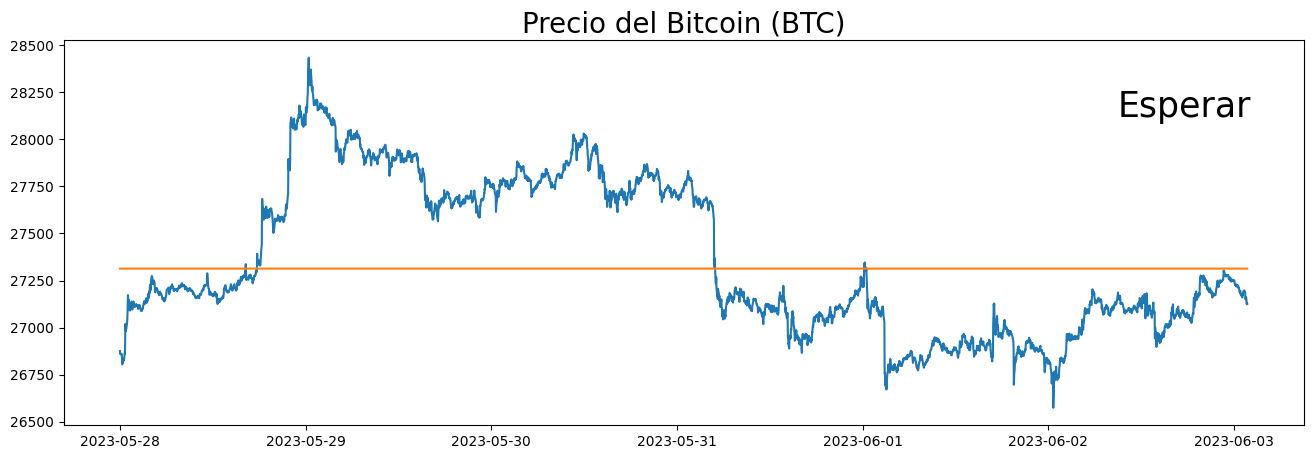

In [7]:
visualizacion()

# Parte 6: Automatización

Listado de las funciones para realización de la tarea de manera automática

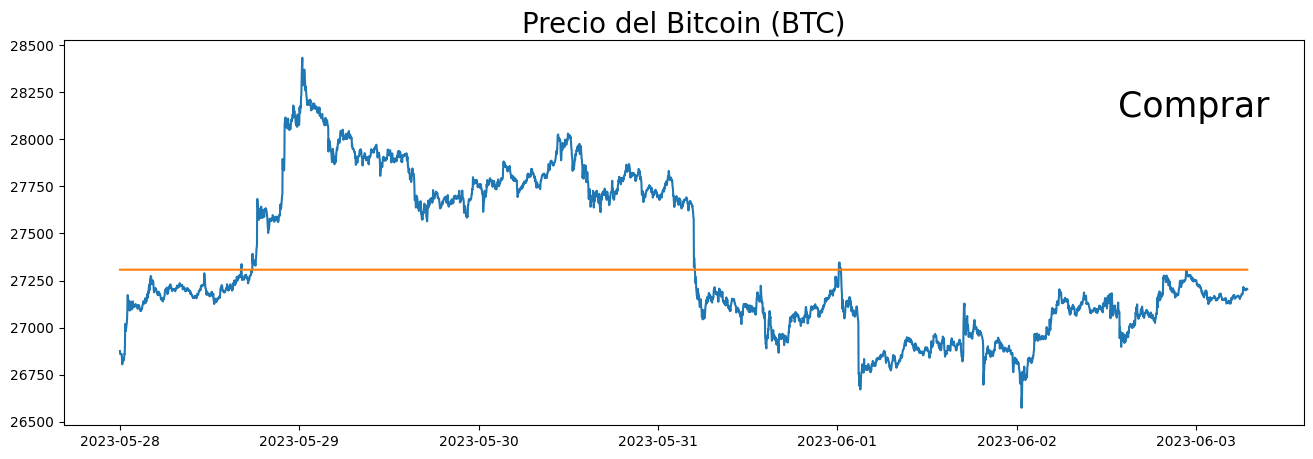

In [8]:
while(True):

    clear_output()
    importar_base_bitcoin()
    extraer_tendencias()
    limpieza_datos()
    tomar_decisiones()
    visualizacion()
    time.sleep(120)
#Función de automatización del proceso en ciclos de cada 2 minutos